# Embeddings

At it's heart a large language model is predicting what is the most likely string of words to come from an input query. Machine learning models struggle to work with data that is not in a numeric format, so our first task is to represent words in a way that can be understood by computers. However, words are complicated. One way we can simplifiy this is to find words which mean similar things. For example, "stupendous" and "nice" mean similar things (a positive reaction) but at different intensities. 

Imagine we have 2 knobs we can turn. One represents "nicesness" and one represents "intensity". Based on that, the "niceness" knob for "nice" and "stupendous" might be very similar, but the "intensity" might be different. Similarly, we can image that the settings for words like "horrible" and "terrible" may be similar. With this intuition, we can represent any word as a specific configuration of different knobs, by twisting and turning to get the perfect match. The examples in this sectino have embeddings with 1024 dimensions (or 1024 different knobs).  

Another way is if we can find a word, such as "Queen", we can calculate how probable is it for another word to be around it. For example, "Elizabeth", "King", "Buckingham" may all be words that are more likely to appear around the word "Queen" compared to something like "bulldozer". As humans, we understand this intuitively. For computers, it may be a lot more difficult. One way to deal with this issue is by looking at "Embeddings", which are a way to representing text as numbers. 

In [264]:
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

True

# Creating an Embedding

Let's find an embedding for a word of our choosing. We will be looking into static embeddings, which are embeddings which have been already assigned to several words already. Through different algorithms that analyze the probability of a word given it's semantic meaning and the context around it, each word is given a specific set of numbers, otherwise known as a "Vector". 

In [265]:
from langchain_dartmouth.embeddings import DartmouthEmbeddings
from langchain_dartmouth.llms import ChatDartmouth

from langchain_core.output_parsers import JsonOutputParser, ListOutputParser

import numpy as np
import pandas as pd
import umap

In [266]:
embeddings = DartmouthEmbeddings()
tiger = embeddings.embed_query("tiger")
print(tiger)
print("Length of tiger: ", len(tiger))

[-0.0098512, 0.021645533, 0.020528702, 0.000515087, -0.03606561, -0.0034401882, -0.019277748, 0.031079523, -0.0088551855, -0.013496476, 0.02126853, 0.0049624527, -0.038428802, 0.013413767, -0.004831469, 0.014840598, -0.019473404, -0.037833326, -0.037558023, -0.00017545157, 0.0143051855, 0.043533113, -0.08317123, -0.023391493, 0.02023354, 0.03892471, 0.008833535, 0.015522147, 0.060258042, 0.009829163, -0.023471642, -0.019778078, 0.04882958, -0.035276916, -0.0027987345, -0.021148305, -0.003931096, -0.0033566123, -0.03245597, -0.0015825863, 0.021915514, -0.06235675, 0.05735998, -0.017271146, -0.018306775, -0.027426377, 0.016969977, -0.045100108, 0.030155057, -0.06374126, 0.008559248, 0.008048475, 0.00875124, -0.023909586, -0.049112137, -0.00404275, -0.019802958, 0.012755762, 0.005984073, 0.016819803, 0.024077311, -0.003208673, 0.039493624, -0.033909094, -0.028675787, -0.016938612, 0.021367928, 0.009030608, 0.01552536, 0.029666582, 0.0012243559, 0.023820473, 0.0014541324, -0.0020722183, -0

We see that the word "tiger" is represented by 1024 numbers. This means that the numeric representation of the word "tiger" consists of 1024 dimensions for this particular embedding model. Other models may use fewer or more numbers to represent a word. 

There are several benefits to having the embedding of a word, a primary one is that it gives us the ability to compare how close two words are in meaning. One way of simpling doing so is by taking the dot product. For example: 

In [267]:
lion = embeddings.embed_query("lion")
eggs = embeddings.embed_query("eggs")

print("Similarity between tiger and lion: ", np.dot(tiger, lion).round(2))
print("Similarity between tiger and eggs:", np.dot(tiger, eggs).round(2))

Similarity between tiger and lion:  0.78
Similarity between tiger and eggs: 0.59


A better way to gain an understanding of this is to visualize it. However, since the data is in 1024 dimensions (an we are, unfotunately, not), we can display this data in a 2 dimensional format using UMAP. Let's generate several embeddings for this

## Embedding a query

In [268]:
llm = ChatDartmouth(model_name="llama-3-1-8b-instruct", seed=42, temperature=0.0)
parser = JsonOutputParser()

chain = llm | parser

response = chain.invoke(
    "Generate 30 different words that are well-suited to showcase how word embeddings work. "
    "Draw the words from domains like animals, finance, and food. The food one should contain tomato "
    "Return the words in JSON format, using the domain as the key, and the words as values. "
)

In [269]:
words = pd.DataFrame.from_dict(response).melt(var_name="domain", value_name="word")

In [270]:
embeddings = DartmouthEmbeddings(model_name="bge-large-en-v1-5")
words["embedding"] = embeddings.embed_documents(words["word"])

In [271]:
mapper = umap.UMAP().fit(np.array(words["embedding"].to_list()))

In [272]:
umap_embeddings = pd.DataFrame(mapper.transform(np.array(words["embedding"].to_list())), columns=["UMAP_x", "UMAP_y"])
# merge with the words
words = pd.concat([words, umap_embeddings], axis=1)
words.head(5)

,domain,word,embedding,UMAP_x,UMAP_y
0,animals,lion,"[0.004938054, 0.01986977, 0.028288273, -0.0261...",12.893116,8.411842
1,animals,tiger,"[-0.0098512, 0.021645533, 0.020528702, 0.00051...",12.180831,7.673333
2,animals,bear,"[0.0003511402, 0.012336012, 0.02718864, 0.0056...",12.570344,7.648190
3,animals,monkey,"[0.0039162966, -0.022503398, -0.00079194736, 0...",12.491144,8.167976
4,animals,giraffe,"[-0.009479101, -0.02422396, -0.0004888569, 0.0...",11.943466,8.221832


By using the UMAP algorithm, we are able to reduce the 1024 dimensional vector into a 2 dimensinoal one. We can now represent this as follows:

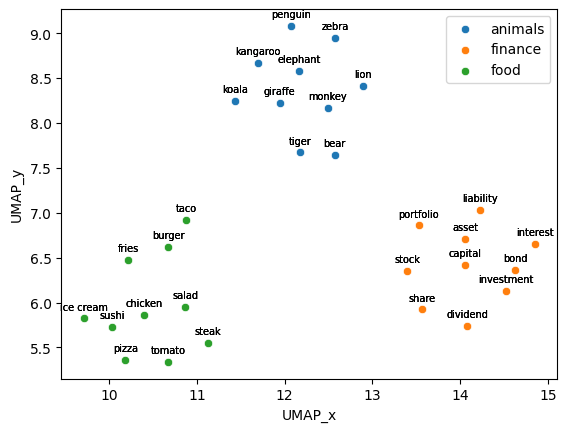

In [273]:
import seaborn as sns

for i in words["domain"].unique():
    sns.scatterplot(data=words[words["domain"] == i], x="UMAP_x", y="UMAP_y", label=i)
    # add the text labels
    for j in range(len(words)):
        plt.text(
            words["UMAP_x"].iloc[j],
            words["UMAP_y"].iloc[j] + 0.13,
            words["word"].iloc[j],
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=7,
        )

We can see that groups with words related to foods, and animals, and finance all are grouped together. The embedding shows that it knows that these words are somewhat similar. 

## Embedding a document

In [401]:
from langchain_dartmouth.llms import DartmouthLLM

llm = ChatDartmouth(model_name="llama-3-1-8b-instruct", seed=42, temperature=0.0)
response1 = llm.invoke("Generate a 100 word text about dartmouth college and it's history and area")

llm = ChatDartmouth(model_name="llama-3-1-8b-instruct", seed=45, temperature=0.8)
response2 = llm.invoke("Generate a 100 word text about dartmouth college and it's history and area")

llm = ChatDartmouth(model_name="llama-3-1-8b-instruct", seed=10, temperature=0.0)
response3 = llm.invoke("Create 100 words of gibberish")


In [406]:
print(response1.content)
print(response2.content)
print(response3.content)

Dartmouth College, located in Hanover, New Hampshire, is the ninth oldest institution of higher education in the United States. Founded in 1769 by Eleazar Wheelock, it was initially established to educate Native American students and prepare them for the ministry. The college's name is derived from William Legge, the 2nd Earl of Dartmouth, who provided significant financial support. Nestled in the picturesque Upper Valley region, Dartmouth's campus spans over 269 acres, offering breathtaking views of the Connecticut River. With a rich history and academic excellence, Dartmouth has become a premier liberal arts institution, attracting students from around the world.
Dartmouth College, located in Hanover, New Hampshire, is one of the oldest and most prestigious institutions of higher learning in the United States. Founded in 1769 by Reverend Eleazar Wheelock, the college was originally intended to educate Native American students, but it quickly evolved into a liberal arts college educat

In [403]:
import numpy as np

def get_embeddings(response):
    words = response.content.split(" ")
    embedding_list = []
    chunks = [words[i:i + 32] for i in range(0, len(words), 32)]
    for chunk in chunks:
        embeddings = DartmouthEmbeddings(model_name="bge-large-en-v1-5")
        embedding_list.append(embeddings.embed_documents(chunk))
    return np.concatenate(embedding_list)

embeddings_1 = get_embeddings(response1)
embeddings_2 = get_embeddings(response2)
embeddings_3 = get_embeddings(response3)

In [404]:
# find the centroid of the embeddings
centroid_1 = np.mean(embeddings_1, axis=0)
centroid_2 = np.mean(embeddings_2, axis=0)
centroid_3 = np.mean(embeddings_3, axis=0)


# find the normalized similarity between the two centroids
similarity_1_2 = np.dot(centroid_1, centroid_2) / (np.linalg.norm(centroid_1) * np.linalg.norm(centroid_2))
similarity_1_3 = np.dot(centroid_1, centroid_3) / (np.linalg.norm(centroid_1) * np.linalg.norm(centroid_3))

# print the similarity
print("Similarity between response 1 and response 2: ", similarity_1_2)
print("Similarity between response 1 and response 3: ", similarity_1_3)

Similarity between response 1 and response 2:  0.9969039603348213
Similarity between response 1 and response 3:  0.8602772979950128


In [405]:
import numpy as np

def get_embeddings(response):
    words = response.content.split(" ")
    embedding_list = []
    chunks = [words[i:i + 32] for i in range(0, len(words), 32)]
    for chunk in chunks:
        embeddings = DartmouthEmbeddings(model_name="bge-large-en-v1-5")
        embedding_list.append(embeddings.embed_documents(chunk))
    return np.concatenate(embedding_list)

embeddings_1 = get_embeddings(response1)
embeddings_2 = get_embeddings(response2)
embeddings_3 = get_embeddings(response3)

In [352]:
# flatten the embeddings


IndexError: list index out of range

# Uses